In [3]:
# Add the parent directory to sys.path
import sys, os
from pathlib import Path

current_directory = os.getcwd()
parent_directory = Path(current_directory).parent.parent
sys.path.insert(0, str(parent_directory))
sys.path

['c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\DLLs',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312\\Lib',
 'C:\\Users\\mekbi\\AppData\\Local\\Programs\\Python\\Python312',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv',
 '',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\mekbi\\Desktop\\Kifiya\\week-2\\telecom-data-analysis\\venv\\Lib\\site-packages\\Pythonwin']

# Connect to database

In [4]:
# Import the utils moudle
from scripts import utils

In [5]:
# Load the credentialsand connect to database
CREDENTIALS  = utils.load_environment_variables(parent_directory=parent_directory)
connection = utils.connect_to_database({"dbname": CREDENTIALS['DB_NAME'],
                                 "user": CREDENTIALS['USER'],
                                 "host": CREDENTIALS['host'],
                                 "port": CREDENTIALS['port']})

INFO:scripts.utils:Trying to load environment variables from c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis/.env
INFO:scripts.utils:Credentials loaded successfully
INFO:scripts.utils:Attempting to connect to the database
INFO:scripts.utils:Connection successful


In [6]:
# Load the db files into pandas dataframe and close the connection
table_name = 'xdr_data'
df = utils.load_data_from_db(conn=connection,
                       table_name=table_name)
utils.close_database_connection(conn=connection)

INFO:root:Executing query: SELECT * FROM xdr_data
c:\Users\mekbi\Desktop\Kifiya\week-2\telecom-data-analysis\scripts\utils.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:scripts.utils:Data loaded into DataFrame successfully
INFO:root:Database connection closed successfully


### Data preparation and cleaning

In [7]:
# Replace outliers
from scripts import experience_utils
relevant_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)',
                    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
                    'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']
modified_df = experience_utils.tukeys_fence(df=df,
                                            columns=relevant_columns)

INFO:root:Q1, Q3, and IQR calculated successfully
INFO:root:Lower bound and upper bound calculated successfully
INFO:root:Tukey's Fence applied successfully


In [8]:
# Fill missing numerical values with the mean
for column in relevant_columns:
    modified_df[column].fillna(modified_df[column].mean(), inplace=True)

C:\Users\mekbi\AppData\Local\Temp\ipykernel_8024\2712465349.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modified_df[column].fillna(modified_df[column].mean(), inplace=True)


In [9]:
# Convert the TCP data to MB
from scripts import enagagement_utils

converted_df = enagagement_utils.convert_bytes_to_megabytes(df=modified_df,
                                                           bytes_column='TCP DL Retrans. Vol (Bytes)',
                                                           gb_column='TCP DL Retrans. Vol (MB)')
converted_df = enagagement_utils.convert_bytes_to_megabytes(df=converted_df,
                                                           bytes_column='TCP UL Retrans. Vol (Bytes)',
                                                           gb_column='TCP UL Retrans. Vol (MB)')
converted_df.head()

INFO:root:Conversion of 'TCP DL Retrans. Vol (Bytes)' to megaytes in column 'TCP DL Retrans. Vol (MB)' successful
INFO:root:Conversion of 'TCP UL Retrans. Vol (Bytes)' to megaytes in column 'TCP UL Retrans. Vol (MB)' successful


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),TCP DL Retrans. Vol (MB),TCP UL Retrans. Vol (MB)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0,1.14786,0.030468
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0,1.14786,0.030468
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0,1.14786,0.030468
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0,1.14786,0.030468
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0,1.14786,0.030468


### Data aggregation

In [10]:
# Aggregate relevant columns per user
aggregation_methods = {
    'Avg RTT DL (ms)': 'sum', 
    'Avg RTT UL (ms)': 'sum',
    'Avg Bearer TP DL (kbps)': 'sum', 
    'Avg Bearer TP UL (kbps)': 'sum',
    'TCP DL Retrans. Vol (MB)': 'sum', 
    'TCP UL Retrans. Vol (MB)': 'sum',}
relevant_df = converted_df.groupby('MSISDN/Number').agg(aggregation_methods).reset_index()
relevant_df.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (MB),TCP UL Retrans. Vol (MB)
0,3.360100e+10,46.000000,0.000000,37.0,39.0,1.147860,0.030468
1,3.360100e+10,30.000000,1.000000,48.0,51.0,1.147860,0.030468
2,3.360100e+10,46.991676,7.621414,48.0,49.0,1.147860,0.030468
3,3.360101e+10,69.000000,15.000000,204.0,44.0,0.001017,0.030468
4,3.360101e+10,114.000000,5.000000,40395.0,103.0,10.064362,0.050687


### KMeans Clustering

In [11]:
# Use the cluster_data utility function from Engagement utilities
from scripts import enagagement_utils
normalized_data = enagagement_utils.normalize_data(df=relevant_df)
clusters = enagagement_utils.cluster_data(normalized_data=normalized_data,
                                          n_clusters=3)
# Add the cluster data to the dataframe
relevant_df['Clusters'] = clusters
# Group the dataframe by the cluster
clustered_data = relevant_df.groupby('Clusters')
clustered_data.head()

INFO:root:K-Means clustering successful, customers classified into three groups


,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (MB),TCP UL Retrans. Vol (MB),Clusters
0,3.360100e+10,46.000000,0.000000,37.0,39.0,1.147860,0.030468,1
1,3.360100e+10,30.000000,1.000000,48.0,51.0,1.147860,0.030468,1
2,3.360100e+10,46.991676,7.621414,48.0,49.0,1.147860,0.030468,1
3,3.360101e+10,69.000000,15.000000,204.0,44.0,0.001017,0.030468,1
4,3.360101e+10,114.000000,5.000000,40395.0,103.0,10.064362,0.050687,0
5,3.360101e+10,67.991676,10.621414,7522.0,386.0,1.150492,0.060935,1
6,3.360101e+10,39.000000,14.000000,40971.0,1542.0,1.241585,0.041868,0
17,3.360103e+10,32.000000,28.000000,34682.0,63.0,2.147625,0.070142,0
29,3.360105e+10,138.983351,48.242829,110.0,112.0,9.664244,0.134466,0
31,3.360105e+10,80.000000,16.000000,23726.0,1221.0,1.161447,0.035659,0


In [12]:
# Compute the minimum, maximum, average, and total for each metric
metrics = ['TCP DL Retrans. Vol (MB)', 'TCP UL Retrans. Vol (MB)', 
           'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 
           'Avg RTT DL (ms)', 'Avg RTT UL (ms)']

min_metrics = clustered_data[metrics].min()
max_metrics = clustered_data[metrics].max()
total_metrics = clustered_data[metrics].sum()
avg_metrics = clustered_data[metrics].mean()

##### Display descriptive statistics

In [13]:
print("Minimum Metrics for each Cluster:")
print(min_metrics)

Minimum Metrics for each Cluster:
          TCP DL Retrans. Vol (MB)  TCP UL Retrans. Vol (MB)  \
Clusters                                                       
0                         0.000036              9.536743e-07   
1                         0.000002              9.536743e-07   
2                         0.042436              6.378174e-03   

          Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  Avg RTT DL (ms)  \
Clusters                                                                      
0                             0.0                      0.0             17.0   
1                             0.0                      0.0              0.0   
2                            69.0                     25.0             58.0   

          Avg RTT UL (ms)  
Clusters                   
0                     1.0  
1                     0.0  
2                    10.0  


In [14]:
print("\nMaximum Metrics for each Cluster:")
print(max_metrics)


Maximum Metrics for each Cluster:
          TCP DL Retrans. Vol (MB)  TCP UL Retrans. Vol (MB)  \
Clusters                                                       
0                        21.424314                  0.403686   
1                         9.978830                  0.193288   
2                        35.999716                  0.692489   

          Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  Avg RTT DL (ms)  \
Clusters                                                                      
0                        119738.0                   7773.0            411.0   
1                         43013.0                   3604.0            213.0   
2                        261472.0                  16127.0            979.0   

          Avg RTT UL (ms)  
Clusters                   
0                    96.0  
1                    50.0  
2                   211.0  


In [15]:
print("\nTotal Metrics for each Cluster:")
print(total_metrics)


Total Metrics for each Cluster:
          TCP DL Retrans. Vol (MB)  TCP UL Retrans. Vol (MB)  \
Clusters                                                       
0                     55669.258211               1462.776773   
1                     95354.755661               2635.097276   
2                     20085.184259                442.838202   

          Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  Avg RTT DL (ms)  \
Clusters                                                                      
0                     609416860.0               23167180.0     2.202447e+06   
1                     176303251.0               17182608.0     4.074503e+06   
2                     220863732.0                7548002.0     7.180330e+05   

          Avg RTT UL (ms)  
Clusters                   
0           397621.884384  
1           556055.731793  
2           179594.955692  


In [16]:
print("\nAverage Metrics for each Cluster:")
print(avg_metrics)


Average Metrics for each Cluster:
          TCP DL Retrans. Vol (MB)  TCP UL Retrans. Vol (MB)  \
Clusters                                                       
0                         2.445173                  0.064250   
1                         1.171161                  0.032365   
2                         7.522541                  0.165857   

          Avg Bearer TP DL (kbps)  Avg Bearer TP UL (kbps)  Avg RTT DL (ms)  \
Clusters                                                                      
0                    26767.552159              1017.577195        96.738583   
1                     2165.382171               211.039291        50.043634   
2                    82720.498876              2826.967041       268.926204   

          Avg RTT UL (ms)  
Clusters                   
0               17.464834  
1                6.829557  
2               67.264028  


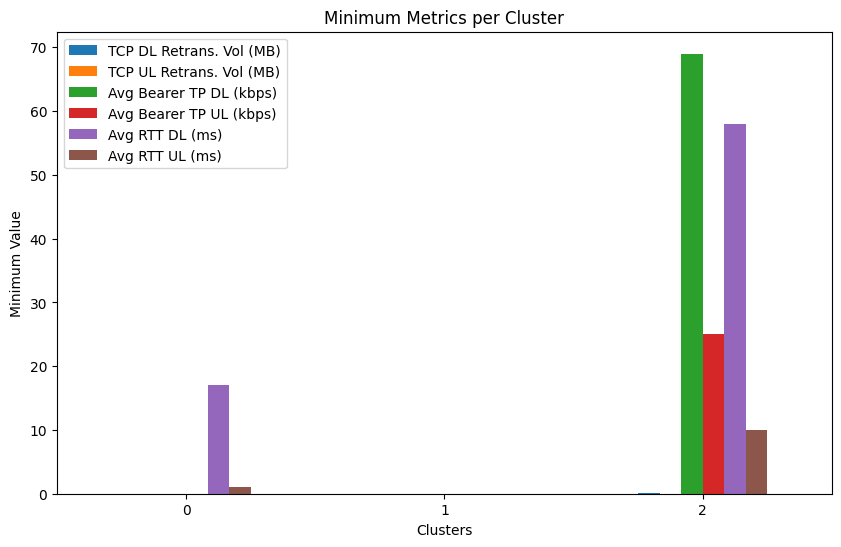

In [17]:
# Draw barcharts for each statistical metric
import matplotlib.pyplot as plt


# Bar plot for minimum metrics per cluster
min_metrics.plot(kind='bar', figsize=(10,6))
plt.title('Minimum Metrics per Cluster')
plt.ylabel('Minimum Value')
plt.xticks(rotation=0)
plt.show()

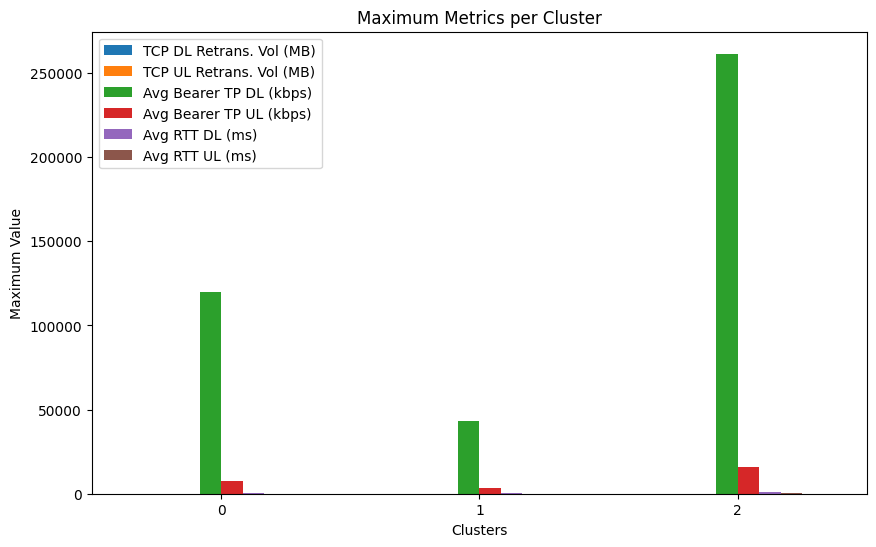

In [18]:
# Bar plot for maximum metrics per cluster
max_metrics.plot(kind='bar', figsize=(10,6))
plt.title('Maximum Metrics per Cluster')
plt.ylabel('Maximum Value')
plt.xticks(rotation=0)
plt.show()

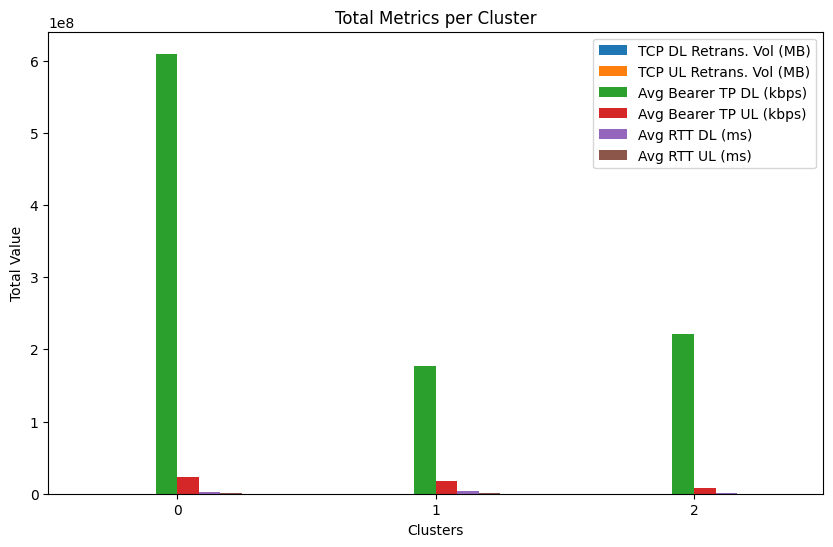

In [19]:
# Bar plot for total metrics per cluster
total_metrics.plot(kind='bar', figsize=(10,6))
plt.title('Total Metrics per Cluster')
plt.ylabel('Total Value')
plt.xticks(rotation=0)
plt.show()

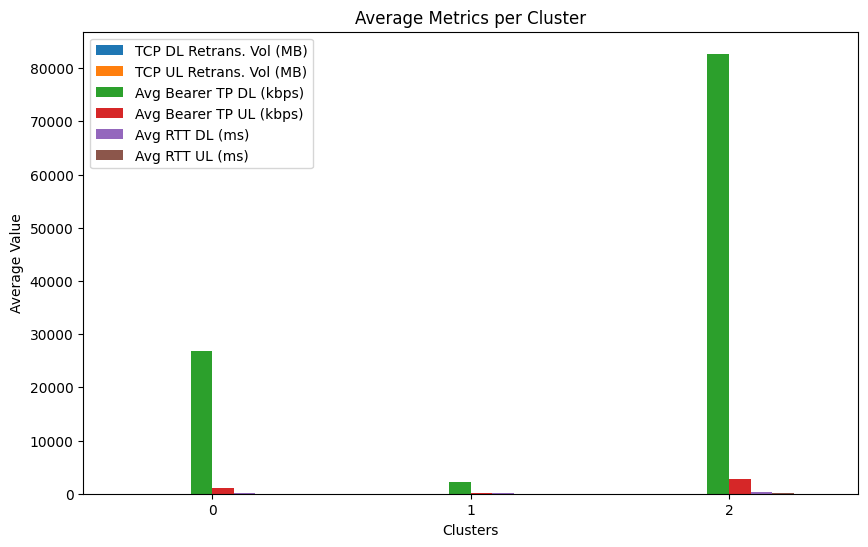

In [20]:
# Bar plot for average metrics per cluster
avg_metrics.plot(kind='bar', figsize=(10,6))
plt.title('Average Metrics per Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.show()